# Sobol Sensitivity Analysis

Here, the goal was to determine whether results of the models were sensitive to small changes in model specification, defined as **second-order** sensitivity indices. This was researched by varying model parameters along with making new predictions. The sensitivity coefficiënt $E$ was calculated by $E = \frac{\delta A}{ \delta F}$, where $\delta A$ represents the percentage of index change and $\delta F$ the percentage of uncertainty change. 


In addition, to study whether results (output) of the model are sensitive to changes in the input data set, **first-order** sensitivity indices were computed. This was done by studying subsets of the dataset that were independently used to make new predictions. In short, **first-order indices** were computed to measure the relative contribution of a single model input to the output variance and **second-order indices** measured the relative contribution by the interaction of model inputs to the output variance. Then, the **total-order index** gives an indication of the relative contribution by a model input to the output variance, including both first- and higher-order interactions. 

In [1]:
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami
import numpy as np
import math
import plotly.express as px

In [2]:
import os
os.chdir("../LSTM")

In [3]:
from core.nn.LSTM_M2 import LSTM_M2

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import datetime
import math

import seaborn as sns
sns.set()
%matplotlib inline

In [4]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


## SA for the LSTM model

In [111]:
DEVICE       = 'cpu'
ThreshConf   = 70
ThreshDead   = 20
TARGET       = "New Confirmed"
TYPE         = "LSTMCell"
FUTURE_DAYS  = 30
RUNS         = 1
ERROR_THRESH = 1
TARGET_NPI   = "Stringency_index"
COUNTRY      = "Netherlands"
TRAIN_UP_TO  = pd.to_datetime("2020-12-06")
DELAY_START  = pd.to_datetime("2020-12-16")


datelist = pd.date_range(pd.to_datetime("2020-11-01"), periods=75).tolist()

def evaluate_model(X):
    errThresh, trainSize, futureDays, hiddenCells, dropoutRate = int(X[0]), datelist[int(X[1])], int(X[2]), int(X[3]), X[4]
    lstm = LSTM_M2(COUNTRY, trainSize, futureDays, trainSize, hiddenCells, dropoutRate, show_Figure=True)
    
    results = lstm.simulate(ThreshConf=errThresh)
    error = results["errors"][0]
    if error == np.nan:
        error = 1
    print(error)
    return error


In [116]:
problem = {
    'num_vars': 5,
    'names': ['errThresh', 'trainSize', 'futureDays', 'hiddenCells', 'dropoutRate'],
    'bounds': [[70, 150],
               [0, 70],
               [10, 30],
               [16, 64],
               [0, 0.8]]
}

In [117]:
param_values = saltelli.sample(problem, 7)
param_values[0]

array([87.578125  ,  6.76757812, 20.37109375, 48.484375  ,  0.22421875])

In [ ]:
Y = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

In [141]:
np.savetxt("output.txt", Y)
np.savetxt("param_values.txt", param_values)

In [126]:
Si = sobol.analyze(problem, Y)

In [139]:
names = [i + " S2" for i in problem["names"]]
df1 = pd.DataFrame(Si["S2"], columns=problem["names"], index=names)

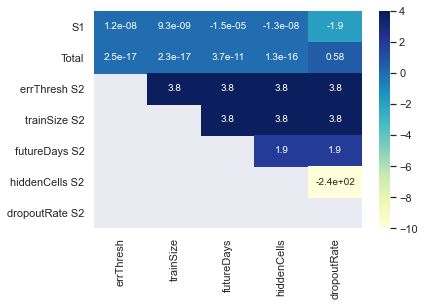

In [163]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.DataFrame(columns=problem["names"])
df.loc["S1"] = Si["S1"]
df.loc["Total"] = Si["ST"]
df = df.append(df1)
sns.heatmap(df, annot=True, vmin=-10, vmax=4, cmap="YlGnBu");

## Morris Method

In [ ]:
param_values_morris = SALib.sample.morris.sample(problem, 7)
param_values_morris[0:3]

Y_morris = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y_morris[i] = evaluate_model(X)
    
    

In [99]:
Si_morris = morris.analyze(problem, param_values_morris, Y_morris, conf_level=0.95, print_to_console=False, num_levels=4)

In [ ]:
df = Si_morris.to_df()

## SA for the SIR model

In [106]:
snl = cs.Scenario(country=COUNTRY, province=None, jhu_data=jhu_data, population_data=population_data)
snl.interactive = True

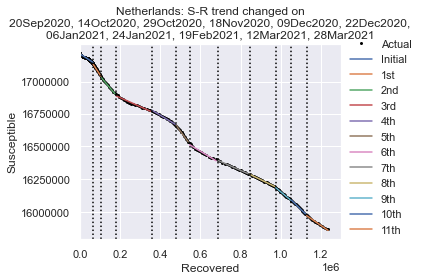

In [107]:
snl.trend()

In [108]:
snl.estimate(cs.SIRF, timeout=180)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 6th phase (12Mar2021 - 27Mar2021): finished 2173 trials in 3 min  1 sec
	 9th phase (06Jan2021 - 23Jan2021): finished  266 trials in 0 min 30 sec
	10th phase (24Jan2021 - 18Feb2021): finished  336 trials in 0 min 40 sec
	 5th phase (14Oct2020 - 28Oct2020): finished  525 trials in 1 min 10 sec
	 3rd phase (28Mar2021 - 13Apr2021): finished  736 trials in 1 min 51 sec
	 0th phase (19Feb2021 - 11Mar2021): finished 1233 trials in 3 min  3 sec
	11th phase (09Dec2020 - 21Dec2020): finished  156 trials in 0 min 20 sec
	 8th phase (20Sep2020 - 13Oct2020): finished 1186 trials in 3 min  2 sec
	 2nd phase (18Nov2020 - 08Dec2020): finished  232 trials in 0 min 30 sec
	 4th phase (22Dec2020 - 05Jan2021): finished 1277 trials in 3 min  2 sec
	 7th phase (15Mar2020 - 19Sep2020): finished 1651 trials in 3 min  1 sec
	 1st phase (29Oct2020 - 17Nov2020): finished 2162 trials in 3 min  1 sec
Completed optimization. Total: 9 min 49